imports

In [1]:
import pandas as pd
import pyarrow


# Reading in data

silver data

In [2]:
# read
silver_test = pd.read_parquet('test-00000-of-00001.parquet')
silver_labels = silver_test["ner_tags"][:200]
silver_labels.drop(silver_labels.index[68], inplace=True)

silver_labels.head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, ...
1           [0, 1, 2, 0, 1, 2, 0, 0, 3, 4, 0, 0, 0, 0]
2                                            [3, 4, 4]
3                       [0, 5, 6, 6, 0, 0, 0, 0, 0, 0]
4                                [1, 2, 2, 0, 3, 4, 0]
Name: ner_tags, dtype: object

gold data

In [3]:
gold_eng = pd.read_csv("gold_eng.csv", sep=";")
columns_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
gold_eng.drop(columns=columns_to_drop, inplace=True)
# Drop the last row explicitly by index
gold_eng.drop(gold_eng.index[-1], inplace=True)
gold_eng.drop(gold_eng.index[-1], inplace=True)
gold_eng


,Labels,Sentences
0,"[0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,5,0,0,0]","[ ""Shortly"", ""afterward"", "","", ""an"", ""encourag..."
1,"[0,1,2,0,1,2,0,0,0,0,0,0,0,0]","[ "":"", ""Kanye"", ""West"", ""featuring"", ""Jamie"", ..."
2,"[3,4,4]","[ ""Blacktown"", ""railway"", ""station"" ]"
3,"[0,0,0,0,0,0,1,0,0,0]","[ ""''"", ""Mycalesis"", ""perseus"", ""lalassis"", ""'..."
4,"[1,2,2,0,0,0,0]","[ ""Jonny"", ""Lee"", ""Miller"", ""-"", ""Eli"", ""Stone..."
...,...,...
194,"[1,2,0,0,0]","[ ""Wesley"", ""Pruden"", ""("", ""2013"", "")"" ]"
195,"[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3...","[ ""Previews"", ""are"", ""scheduled"", ""to"", ""begin..."
196,"[5,0,5,0,5]","[ ""China"", "","", ""Indonesia"", "","", ""Vietnam"" ]"
197,"[3,4,4,4,4,4]","[ ""Emmett"", ""/"", ""Furla"", ""/"", ""Oasis"", ""Films"" ]"


converting to list of list

In [4]:
gold_words = gold_eng["Sentences"].values.tolist()
gold_labels = gold_eng["Labels"].values.tolist()


In [5]:
silver_labels_list=[(string_list).tolist() for string_list in silver_labels]
gold_labels_list=[eval(string_list) for string_list in gold_labels]
gold_word_list = [eval(string_list) for string_list in gold_words]


# preprocessing the data

In [6]:
from transformers import AutoTokenizer, Trainer

model_checkpoint = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
import pandas as pd
label_all_tokens = True

In [8]:
def tokenize_and_align_labels(sentences, tags, tokenizer):
    tokenized_inputs = tokenizer(sentences, truncation=True, is_split_into_words=True, padding=True)

    aligned_labels = []
    for i, label in enumerate(pd.Series(tags)):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        aligned_labels.append(label_ids)

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs.data

In [9]:
tokenized_gold_data = tokenize_and_align_labels(gold_word_list, gold_labels_list, tokenizer)
tokenized_silver_data = tokenize_and_align_labels(gold_word_list, silver_labels_list, tokenizer)

In [10]:
#tokenized_gold_data

In [11]:
from datasets import Dataset

In [66]:
gold_dataset = Dataset.from_dict({
    'id': range(len(tokenized_gold_data['input_ids'])),
    'input_ids': tokenized_gold_data['input_ids'],
    'attention_mask': tokenized_gold_data['attention_mask'],
    'labels': tokenized_gold_data['labels']
})


silver_dataset = Dataset.from_dict({
    'id': range(len(tokenized_silver_data['input_ids'])),
    'input_ids': tokenized_silver_data['input_ids'],
    'attention_mask': tokenized_silver_data['attention_mask'],
    'labels': tokenized_silver_data['labels']
})


import pickle

# Save gold_dataset
with open('mbert_eng_gold_gold_dataset.pickle', 'wb') as f:
    pickle.dump(gold_dataset, f)

# Save silver_dataset
with open('mbert_eng_gold_silver_dataset.pickle', 'wb') as f:
    pickle.dump(silver_dataset, f)

# Quality checking lengths of the annotations

In [67]:
# Check if lengths are equal and aligned
lengths_equal = all(len(gold_labels) == len(sentences) for gold_labels, sentences in zip(gold_labels_list, gold_word_list))

print("Are lengths equal and aligned:", lengths_equal)

Are lengths equal and aligned: True


In [68]:
silver_labels_list = [(string_list).tolist() for string_list in silver_labels]
gold_labels_list = [eval(string_list) for string_list in gold_labels]
gold_word_list = [eval(string_list) for string_list in gold_words]

# Check if all lists have the same length at each index
for i in range(min(len(silver_labels_list), len(gold_labels_list), len(gold_word_list))):
    silver_len = len(silver_labels_list[i])
    gold_len = len(gold_labels_list[i])
    word_len = len(gold_word_list[i])
    
    if silver_len != gold_len or silver_len != word_len:
        print(f"At index {i}: Silver labels length = {silver_len}, Gold labels length = {gold_len}, Gold words length = {word_len}")
        


# using test data on saved model

In [69]:
#gold_dataset

In [70]:
from transformers import AutoTokenizer, Trainer,AutoModelForTokenClassification

In [71]:
loaded_model = AutoModelForTokenClassification.from_pretrained("eng_mbert")

In [72]:
loaded_model.to("cuda:0")

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [73]:
#loaded_model

import pickle

with open('gold_dataset.pickle','rb') as f:
    eng_gold = pickle.load(f)

In [74]:
loaded_model.device.type

'cuda'

In [75]:
trainer = Trainer(model = loaded_model)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [76]:
trainer.evaluate(gold_dataset)

{'eval_loss': 1.6918050050735474,
 'eval_runtime': 0.4019,
 'eval_samples_per_second': 495.161,
 'eval_steps_per_second': 62.206}

In [77]:
trainer.predict(gold_dataset)

In [78]:
loaded_model.to("cuda:0")

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [79]:
import numpy as np


In [80]:
id2label = {0: '0',
            1: 'B-PER', 
            2: 'I-PER',
            3: 'B-ORG',
            4: 'I-ORG',
            5: 'B-LOC',
            6: 'I-LOC'
           }

In [81]:
label2id = {label: id for id, label in id2label.items()}

In [82]:
label_names = list(label2id.keys())

In [83]:
from datasets import load_metric

In [84]:
metric = load_metric("seqeval")

/home/jhag/.local/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [85]:
predictions, labels, metrics = trainer.predict(gold_dataset)
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

/home/jhag/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'LOC': {'precision': 0.5363128491620112,
  'recall': 0.7384615384615385,
  'f1': 0.6213592233009709,
  'number': 130},
 'ORG': {'precision': 0.5347222222222222,
  'recall': 0.7623762376237624,
  'f1': 0.6285714285714287,
  'number': 101},
 'PER': {'precision': 0.8636363636363636,
  'recall': 0.76,
  'f1': 0.8085106382978724,
  'number': 150},
 '_': {'precision': 0.5225806451612903,
  'recall': 0.627906976744186,
  'f1': 0.5704225352112675,
  'number': 129},
 'overall_precision': 0.6032786885245902,
 'overall_recall': 0.7215686274509804,
 'overall_f1': 0.657142857142857,
 'overall_accuracy': 0.8058336961253809}

In [86]:
from sklearn.metrics import confusion_matrix

In [87]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Flatten true labels and predicted labels
true_labels_flat = [label for sublist in true_labels for label in sublist]
predicted_labels_flat = [label for sublist in true_predictions for label in sublist]

# Get unique labels
unique_labels = sorted(list(set(true_labels_flat + predicted_labels_flat)))

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels_flat, predicted_labels_flat, labels=unique_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1085   48   44    6   50  111   30]
 [   7  102    3    0    4   14    0]
 [   1    7   83    5    0    3    1]
 [  17    4    5  119    2    1    2]
 [  12   17    3    1   85    8    2]
 [   3    0    4    0   15  132    6]
 [   4    0    0    1    4    1  245]]


<Figure size 1000x800 with 0 Axes>

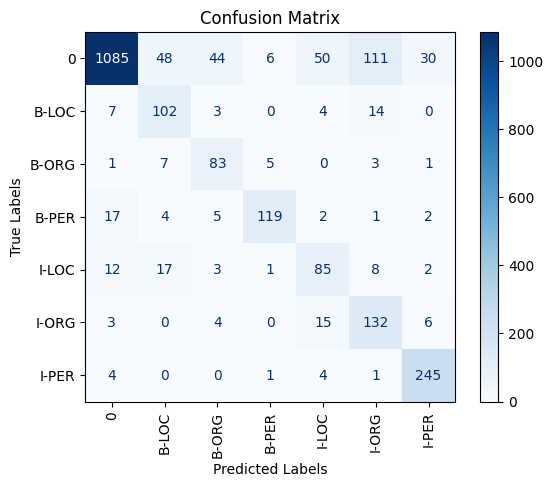

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp = disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("confusion_gold_mbert")
plt.show()


In [92]:
for i in range(len(true_predictions)):
    print("Example", i+1)
    print("Predicted:", true_predictions[i])
    print("Real:", true_labels[i], "\n")
       

Example 1
Predicted: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-LOC', '0', '0', '0', '0', 'B-LOC', 'B-LOC', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-LOC', '0', '0', '0', '0', 'B-LOC', 'B-LOC', '0', '0', '0'] 

Example 2
Predicted: ['0', 'B-PER', 'I-PER', '0', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', 'B-ORG', 'I-ORG', 'I-ORG', '0', '0', '0', '0', '0']
Real: ['0', 'B-PER', 'I-PER', '0', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'] 

Example 3
Predicted: ['B-ORG', 'B-ORG', 'I-ORG', 'I-ORG']
Real: ['B-ORG', 'B-ORG', 'I-ORG', 'I-ORG'] 

Example 4
Predicted: ['0', '0', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-PER', 'B-PER', 'B-PER', '0', '0', '0'] 

Example 5
Predicted: ['B-PER', 'B-PER', 'I-PER', 'I-PER', '0', 'B-PER', 'I

In [90]:
for i in range(len(true_predictions)):
    if true_predictions[i] != true_labels[i]:
        print("Example", i+1)
        print("Predicted:", true_predictions[i])
        print("Real:", true_labels[i])
   


Example 2
Predicted: ['0', 'B-PER', 'I-PER', '0', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', 'B-ORG', 'I-ORG', 'I-ORG', '0', '0', '0', '0', '0']
Real: ['0', 'B-PER', 'I-PER', '0', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Example 4
Predicted: ['0', '0', 'B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B-PER', 'B-PER', 'B-PER', '0', '0', '0']
Example 5
Predicted: ['B-PER', 'B-PER', 'I-PER', 'I-PER', '0', 'B-PER', 'I-PER', '0', '0']
Real: ['B-PER', 'B-PER', 'I-PER', 'I-PER', '0', '0', '0', '0', '0']
Example 6
Predicted: ['B-LOC', 'B-LOC', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', '0', '0', '0', '0']
Real: ['0', '0', '0', '0', '0', '0', '0', '0', 'B-PER', 'B-PER']
Example 7
Predicted: ['B-ORG', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG']
Real: ['0', '0', '0', '0', '0', '0', '0', 'B-LOC', 'I